In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

不同的带电粒子在磁场中运动的轨迹参数和在探测器中留下的信息是不一样的。
本项目是利用利用粒子在探测器中的飞行信息和击中信息，对粒子种类进行鉴别。待鉴别粒子种类为$\pi$介子(pion),K介子(kaon)，质子(proton)。对应标签为Type：0,1,2

In [2]:
train_pi = pd.read_csv('Pi.dat',header=None,sep=' ')
train_k = pd.read_csv('K.dat',header=None,sep=' ')
train_p = pd.read_csv('Proton.dat',header=None,sep=' ')

test_pi = pd.read_csv('test/Pi.dat',header=None,sep=' ')
test_k = pd.read_csv('test/K.dat',header=None,sep=' ')
test_p = pd.read_csv('test/Proton.dat',header=None,sep=' ')

train_tot = pd.concat((train_pi,train_k,train_p))
test_tot = pd.concat((test_pi,test_k,test_p))


train_tot.columns=['P','CosTheta','CosPhi','PH','GoodHit','Tof','E','Eseed','E3x3','E5x5','secp','Type']
test_tot.columns=['P','CosTheta','CosPhi','PH','GoodHit','Tof','E','Eseed','E3x3','E5x5','secp','Type']




print(train_tot.shape)
print(test_tot.shape)


(30000, 12)
(9000, 12)


## 1.数据处理
通过蒙特卡洛法产生3种粒子每种1万共3万个事例作为训练数据，每种3000共9000事例作为测试数据。共记录每个事例的11个参数，参数从左到右分别为
动量（P），极角（CosTheta），方位角（CosPhi），脉冲信号（PH），信号击中数（GoodHit），飞行时间（Tof），能量（E），种子能量（Eseed），3x3晶格能量（E3x3），5x5晶格能量（E5x5），能量分布二阶矩（secp）

#### 关于能量
粒子能量是通过一个平面网格化的量能器来获取的，粒子击中一个晶格种子后，沉积下一部分能量，并且此能量会在周围的晶格扩散，因此会有种子能量、3x3晶格、5x5晶格的能量，能量二阶矩用于衡量扩散的范围。

### 数据清洗
首先观察一下各列数据的分布

In [3]:
train_tot.describe()

,P,CosTheta,CosPhi,PH,GoodHit,Tof,E,Eseed,E3x3,E5x5,secp,Type
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000
mean,0.668439,0.002645,0.013356,665.216982,24.926700,557.878106,0.266209,0.133144,0.204551,0.221745,15.608768,1.00000
std,0.212842,0.515939,0.705820,373.651215,3.743411,2285.722725,0.132361,0.071819,0.113894,0.129649,15.240440,0.81651
min,0.166529,-0.937174,-0.999999,284.333000,2.000000,-38.016000,0.009426,0.006006,0.007086,0.009304,0.022062,0.00000
25%,0.522583,-0.431418,-0.692221,432.919250,24.000000,3.440852,0.184178,0.083327,0.134869,0.144621,5.186290,0.00000
50%,0.692846,0.000306,0.030577,540.532000,25.000000,4.305650,0.233632,0.121662,0.182061,0.191234,11.654300,1.00000
75%,0.845844,0.445677,0.714956,790.393000,27.000000,5.409830,0.333184,0.172164,0.265010,0.287990,22.581975,2.00000
max,0.999993,0.940299,1.000000,8346.460000,36.000000,9999.000000,0.996383,0.868196,0.898794,0.935662,372.488000,2.00000


下边画一下各个变量的分布情况

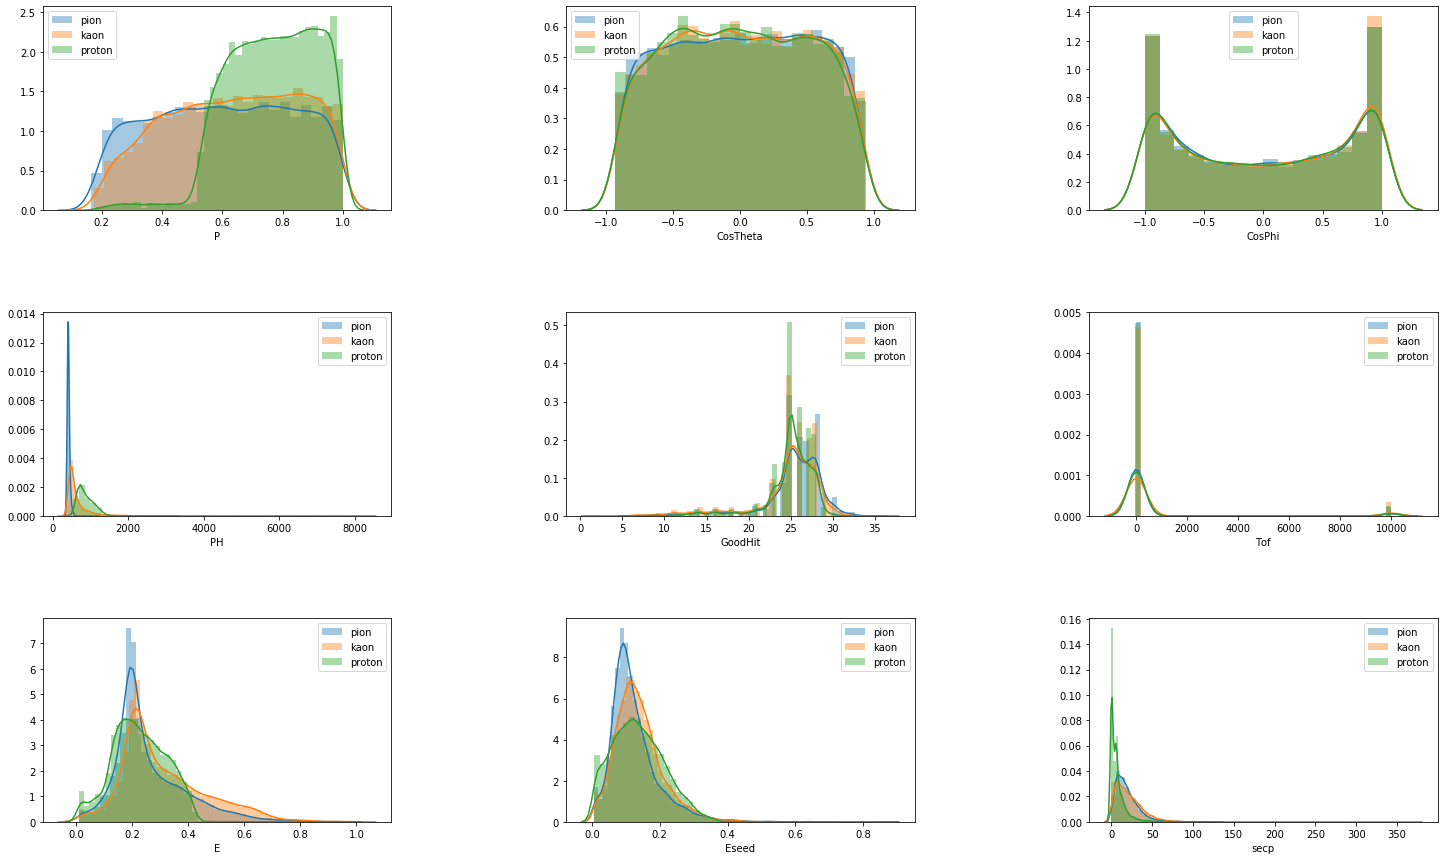

In [4]:
plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距
plt.subplot(331)
sns.distplot(train_tot.loc[train_tot['Type']==0,'P'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'P'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'P'],label=u'proton')

plt.legend(loc='best')

plt.subplot(332)
sns.distplot(train_tot.loc[train_tot['Type']==0,'CosTheta'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'CosTheta'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'CosTheta'],label=u'proton')

plt.legend(loc='best')

plt.subplot(333)
sns.distplot(train_tot.loc[train_tot['Type']==0,'CosPhi'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'CosPhi'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'CosPhi'],label=u'proton')

plt.legend(loc='best')

plt.subplot(334)
sns.distplot(train_tot.loc[train_tot['Type']==0,'PH'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'PH'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'PH'],label=u'proton')

plt.legend(loc='best')

plt.subplot(335)
sns.distplot(train_tot.loc[train_tot['Type']==0,'GoodHit'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'GoodHit'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'GoodHit'],label=u'proton')

plt.legend(loc='best')

plt.subplot(336)
sns.distplot(train_tot.loc[train_tot['Type']==0,'Tof'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'Tof'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'Tof'],label=u'proton')

plt.legend(loc='best')

plt.subplot(337)
sns.distplot(train_tot.loc[train_tot['Type']==0,'E'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'E'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'E'],label=u'proton')

plt.legend(loc='best')

plt.subplot(338)
sns.distplot(train_tot.loc[train_tot['Type']==0,'Eseed'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'Eseed'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'Eseed'],label=u'proton')

plt.legend(loc='best')

plt.subplot(339)
sns.distplot(train_tot.loc[train_tot['Type']==0,'secp'],label=u'pion')
sns.distplot(train_tot.loc[train_tot['Type']==1,'secp'],label=u'kaon')
sns.distplot(train_tot.loc[train_tot['Type']==2,'secp'],label=u'proton')

plt.legend(loc='best')

可以看到有些特征对分类的影响还是很高的，比如能量E，Eseed，PH。

有些特征是存在异常值的，比如飞行时间Tof，脉冲高度PH以及secp等，之后会对这些特征进行进一步处理，提高分类准确度。



### 异常值处理



首先我们处理飞行时间Tof，
从Tof的大致分布可以看到，飞行时间基本上处于(2-10)区间，而根据上图又有很多事例其飞行时间固定在9999。因此需要分别对这几种情况进行处理。

首先对于值小于0时，可以认为是探测器计算此值时出现异常，因为飞行时间一定是大于0的，出现这种情况的事例少于1%，

飞行时间大于15的事例也可以认为是异常事例，总数约占0.3%。

最后是飞行时间为9999的，这种事例占比超过5%。查看原始数据发现，这些事例是由于粒子没有击中飞行时间探测器造成的(因为探测器是有缝隙，粒子可能从缝隙中飞出)。对于这种存在大量异常值的数据，可以有以下几种处理方法：
>* 1.不处理，这种方法可以避免引入噪声。有些模型能够自动对这些异常值处理得好，有些对距离敏感的分类器则会导致性能下降(如KNN)
>* 2.直接填充均值，这种方法十分简单，但是可能会引入噪声，改变填充后的数据分布
>* 3.热卡填补，此法是在完整数据中找一个与其最相似的对象，并用其值来填充。此法主观性较强，因此需要自行挑选用哪些特征来进行匹配，但是如果对数据的类型比较熟悉的话，此法会比较有效，因此下边将会用此法进行异常值校正。
>* 4.拟合，利用其他变量对异常值进行预测，此法与正常建模方法一样，只是目标变量变为预测值。但是这种方法得出的值可能会对最后的建模起不到太大作用，因为此预测值必然与其他特征相关性较高。


Tof<0 数据占比:  0.0002
15<Tof<9999 数据占比:  0.0026333333333333334
Tof==9999 数据占比:  0.05536666666666667


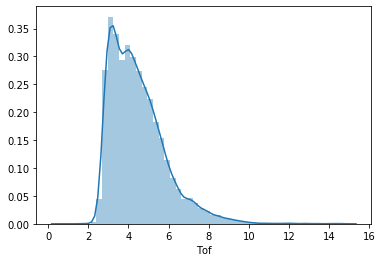

In [5]:
sns.distplot(train_tot.loc[((train_tot['Tof']<15)&(train_tot['Tof']>0)),'Tof'])
#plt.show()
print("Tof<0 数据占比: ", train_tot[train_tot['Tof']<=0].count()[0]/train_tot.shape[0])
print("15<Tof<9999 数据占比: ",train_tot.loc[(train_tot['Tof']>15)&(train_tot['Tof']<9999)].count()[0]/train_tot.shape[0])
print("Tof==9999 数据占比: ",train_tot[train_tot['Tof']==9999].count()[0]/train_tot.shape[0])

在此处我决定用动量P和极角CosTheta来匹配对应的飞行时间，因为飞行时间必然与粒子的速度(动量)和飞行距离相关，而由于探测器是圆柱体结构，所以粒子出射角度(CosTheta)与飞行距离相关。
匹配方法为：将动量P和极角CosTheta各分成5个区间，总共有25个子区间。求出每个区间粒子的Tof中位数。将Tof异常值的事例根据其动量和极角匹配到区间中的Tof值

In [6]:

guess_TOF=np.zeros((5,5))
step_P=(train_tot['P'].max()-train_tot['P'].min())/5
step_Cos=(train_tot['CosTheta'].max()-train_tot['CosTheta'].min())/5

MinP=train_tot['P'].min()
MinC=train_tot['CosTheta'].min()

#填充25个小区间里Tof的中位数
for i in range(0,5):
    for j in range(0,5):
        guess_data=train_tot[(train_tot['P']>=MinP+(i*step_P))&(train_tot['P']<MinP+(i+1)*step_P)
                        &(train_tot['CosTheta']>=MinC+j*step_Cos)&(train_tot['CosTheta']<MinC+(j+1)*step_Cos)
                        ]['Tof'].median()
        
        guess_TOF[i,j]=guess_data
        #print(guess_data)
        
combine = [train_tot,test_tot]
for data in combine:

    for i in range(0,5):
        for j in range(0,5):
            data.loc[(data['P']>=MinP+(i*step_P))&(data['P']<MinP+(i+1)*step_P)
            &(data['CosTheta']>=MinC+j*step_Cos)&(data['CosTheta']<MinC+(j+1)*step_Cos)
             &((data['Tof']>15)|(data['Tof']<0)),'Tof']=guess_TOF[i,j]
            #print(guess_TOF[i,j])
      


由之前的分布图可以看到，PH，TOF，secp是有一些数据异常偏高，为了修正该情况，首先看看正常区间下它们的分布

In [7]:
PH_mean = train_tot['PH'].mean()
PH_std  = train_tot['PH'].std()
secp_mean = train_tot['secp'].mean()
secp_std = train_tot['secp'].std()
print("PH异常分布事例占比：",train_tot[train_tot['PH']>PH_mean+5*PH_std].shape[0]/train_tot.shape[0])
print("secp异常分布事例占比：",train_tot[train_tot['secp']>secp_mean+5*secp_std].shape[0]/train_tot.shape[0])


PH异常分布事例占比： 0.0047
secp异常分布事例占比： 0.0015


可以看到PH和secp分布异常事例占比不多，分别约0.4%和0.02%。下边先看看热力图，观察这两者与哪些变量相关性较高。

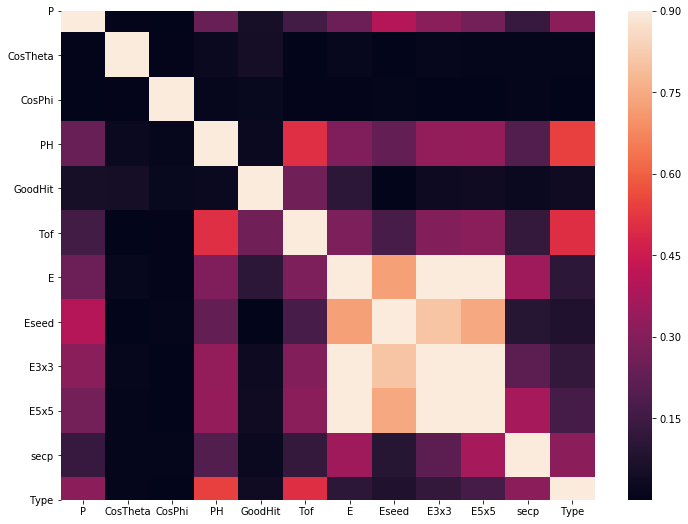

In [8]:
corrmat = abs(train_tot.corr())
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [9]:
print("PH 相关性较高的列：\n",abs(train_tot.corr()['PH']).sort_values(ascending=False)[0:5])
print("\n secp 相关性较高的列：\n",abs(train_tot.corr()['secp']).sort_values(ascending=False)[0:5])

PH 相关性较高的列：
 PH      1.000000
Type    0.543523
Tof     0.506949
E5x5    0.336982
E3x3    0.332814
Name: PH, dtype: float64

 secp 相关性较高的列：
 secp    1.000000
E5x5    0.369809
E       0.357474
Type    0.314586
E3x3    0.216369
Name: secp, dtype: float64


从相关性矩阵可以看到，E，Eseed，E3x3，E5x5这三者相关性是很高的。之后可以考虑删除Eseed，E3x3,E5x5三列

PH与Tof的相关性比较高，可以用他们的相关性来填充PH的异常值

E与secp的相关性较高，可以用他们的相关性来填充secp的异常值

In [10]:
train_tot.drop(['Eseed','E3x3','E5x5'],axis=1,inplace=True)
test_tot.drop(['Eseed','E3x3','E5x5'],axis=1,inplace=True)

In [11]:

guess_PH=np.zeros((5))
step_Tof=(train_tot['Tof'].max()-train_tot['Tof'].min())/5

MinTof=train_tot['Tof'].min()

for i in range(0,5):
    guess_data=train_tot[(train_tot['Tof']>=MinTof+(i*step_Tof))&(train_tot['Tof']<MinTof+(i+1)*step_Tof)
                    ]['PH'].median()
        
    guess_PH[i]=guess_data
        
combine = [train_tot,test_tot]
for data in combine:
    for i in range(0,5):
        data.loc[(data['Tof']>=MinTof+(i*step_Tof))&(data['Tof']<MinTof+(i+1)*step_Tof)
         &((data['PH']>PH_mean+5*PH_std)),'PH']=guess_PH[i]
            #print(guess_TOF[i,j])
      


In [12]:

guess_secp=np.zeros((5))
step_E=(train_tot['E'].max()-train_tot['E'].min())/5

MinE=train_tot['E'].min()

for i in range(0,5):
    guess_data=train_tot[(train_tot['E']>=MinE+(i*step_E))&(train_tot['E']<MinE+(i+1)*step_E)
                    ]['secp'].median()
        
    guess_secp[i]=guess_data
    #print(guess_secp)
        
combine = [train_tot,test_tot]
for data in combine:
    for i in range(0,5):
        data.loc[(data['E']>=MinE+(i*step_E))&(data['E']<MinE+(i+1)*step_E)
         &((data['secp']>secp_mean+5*secp_std)),'secp']=guess_secp[i]
            #print(guess_TOF[i,j])
      


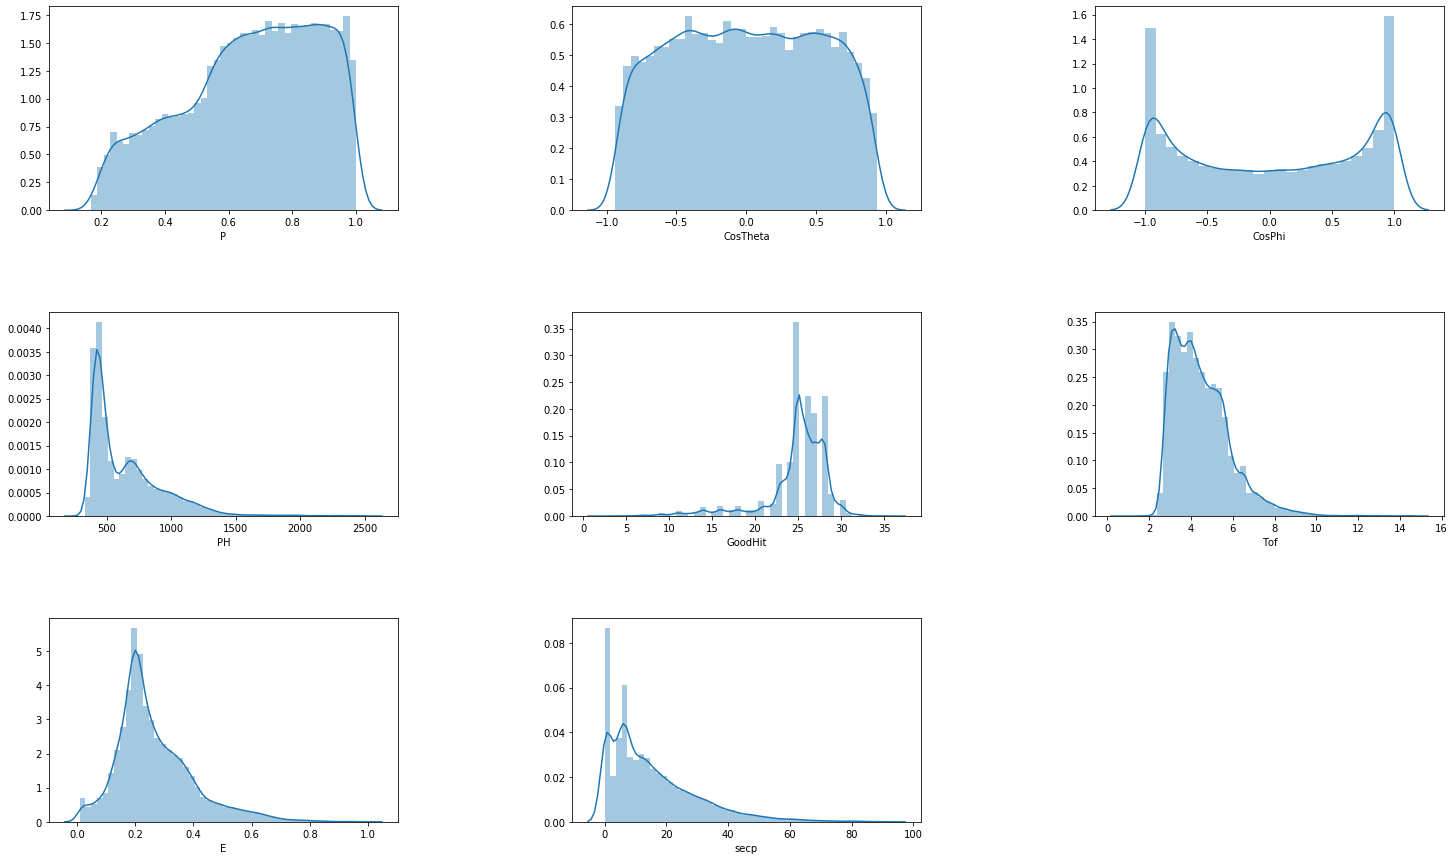

In [13]:
plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距
plt.subplot(331)
sns.distplot(train_tot['P'])

plt.subplot(332)
sns.distplot(train_tot['CosTheta'])



plt.subplot(333)
sns.distplot(train_tot['CosPhi'])


plt.subplot(334)
sns.distplot(train_tot['PH'])

plt.subplot(335)
sns.distplot(train_tot['GoodHit'])

plt.subplot(336)
sns.distplot(train_tot['Tof'])

plt.subplot(337)
sns.distplot(train_tot['E'])



plt.subplot(338)
sns.distplot(train_tot['secp'])



可以看到调整异常数据之后所有分布都比较集中了。下一步将要调整一下数据的分布，可以看到有些列比如Tof，E，secp这些都是明显有偏度的，将他们的偏度减少可以有利于数据拟合

In [14]:
train_tot.skew().sort_values()

GoodHit    -2.048475
P          -0.414503
CosPhi     -0.027985
CosTheta   -0.008726
Type        0.000000
E           1.124086
Tof         1.287858
secp        1.398650
PH          1.749650
dtype: float64

下边会将偏度大于0.75的列通过变换尽量将偏度变回0，这里使用的是boxcox1p变换，详情可以查看http://onlinestatbook.com/2/transformations/box-cox.html 

通过不同的$\lambda$值可以将列的偏度变换，因为每列的偏度都不一样，所以选取不同的$\lambda$值，让其自行挑选合适的值。

In [15]:
skew_col=train_tot.skew()[abs(train_tot.skew())>0.75].index

from scipy.special import boxcox1p
lam = [-4,-3,-2,-1,0,0.1,0.2,0.3,0.5,0.8,1,2,3,4]
for feat in skew_col:
    skew_val = train_tot[feat].skew()
    for val in lam:
        train_ch = boxcox1p(train_tot[feat], val)
        test_ch = boxcox1p(test_tot[feat], val)
        if(abs(train_ch.skew())<abs(skew_val)):
            skew_val = train_ch.skew()
            train_value = train_ch
            test_value = test_ch
    train_tot[feat] = train_value
    test_tot[feat] = test_value

train_tot[skew_col].skew().sort_values(ascending=False)

E          0.087809
PH         0.000000
secp      -0.014843
Tof       -0.037363
GoodHit   -0.120666
dtype: float64

可以看到在变换之后，原先偏度较大的数据现在偏度基本都在0.1以下。

# 2.建模

数据清洗完毕之后就要开始建模了，打算使用几个不同的模型，利用sklearn里的GridSearch调参达到最高准确率之后，利用Stacking融合的方式获得最佳分类结果

In [16]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,roc_curve
import xgboost as xgb
import sklearn
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize





In [17]:
train_tot=train_tot.sample(frac=1)

X_train = train_tot.drop(['Type'],axis = 1).values
Y_train = train_tot[['Type']].values

X_test = test_tot.drop(['Type'],axis = 1).values
Y_test = test_tot[['Type']].values


ro=RobustScaler()
X_test_=ro.fit_transform(X_test)

首先是XGBoost与LightGBM这两个集成方法。这些集成方法在调参时一般先将学习率调整得较高，使训练速度加快。调参的顺序一般为：

>* 1.max_depth,min_child_weight。最大深度，叶节点最小权重
>* 2.Gamma 节点分裂所需的最小损失函数下降值
>* 3.subsample colsample_bytree每个树选取的样本比例和特征比例
>* 4.reg_alpha reg_lambda 正则化参数
>* 5.learning_rate 学习率

在此处调参用的是sklearn内置的GridSearchCV模块，其可以指定需要调整的参数范围，并自动内置交叉验证来算出准确率最高的参数值。

在进入训练前，首先要将数据进行归一化处理，此处用的归一化方式为RobustScaler，将数据减去均值，再除以标准差。其中均值和标准差都是用位于四分之一位数到四分之三位数之间的数据进行计算，有效防止离群点对样本的影响。

此处归一化时采用sklearn内置的make_pipeline技术，可以看成是一个管道，将一些步骤进行打包处理。对于每种算法可能会有不同的预处理方法，采用pipeline可以有效防止原始数据被污染。

In [18]:
cv_params = {'learning_rate': [0.01,0.02,0.03,0.05,0.1,0.2]}
other_params = { 'max_depth': 12, 'subsample': 0.9, 'n_estimators': 300,'min_child_weight':3,
'gamma':0.5,'colsample_bytree': 0.9, 'objective': 'multiclass', 'eval_metric': 'merror', 'silent': False, 'nthread': 8,
               'learning_rate':0.1,'reg_alpha':0.1,'reg_lambda':0}

model = xgb.XGBClassifier(**other_params)
optimized_XGB = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=4, verbose=1, n_jobs=-1)

XGB=make_pipeline(RobustScaler(), optimized_XGB)

XGB.fit(X_train, Y_train,gridsearchcv__eval_set=[(X_test_,Y_test)]
              ,gridsearchcv__eval_metric='merror',gridsearchcv__early_stopping_rounds=30)
evalute_result = optimized_XGB.cv_results_
#print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_XGB.best_params_))
print('最佳模型得分:{0}'.format(optimized_XGB.best_score_))

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.5min finished


[0]	validation_0-merror:0.044889
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.045333
[2]	validation_0-merror:0.045
[3]	validation_0-merror:0.040444
[4]	validation_0-merror:0.039
[5]	validation_0-merror:0.038444
[6]	validation_0-merror:0.037111
[7]	validation_0-merror:0.036111
[8]	validation_0-merror:0.036333
[9]	validation_0-merror:0.035667
[10]	validation_0-merror:0.034889
[11]	validation_0-merror:0.035222
[12]	validation_0-merror:0.034222
[13]	validation_0-merror:0.034556
[14]	validation_0-merror:0.033889
[15]	validation_0-merror:0.033778
[16]	validation_0-merror:0.033
[17]	validation_0-merror:0.032667
[18]	validation_0-merror:0.032667
[19]	validation_0-merror:0.032778
[20]	validation_0-merror:0.032889
[21]	validation_0-merror:0.032556
[22]	validation_0-merror:0.032667
[23]	validation_0-merror:0.032444
[24]	validation_0-merror:0.032
[25]	validation_0-merror:0.032444
[26]	validation_0-merror:0.032333
[27]	validation_0-merror:0.032333
[28

In [34]:
params = { 'max_depth': 12, 'subsample': 0.9, 'n_estimators': 200,'min_child_weight':3,
'gamma':0.5,'colsample_bytree': 0.9, 'objective': 'multiclass', 'eval_metric': 'merror', 'silent': False, 'nthread': 8,
               'learning_rate':0.1,'reg_alpha':0.1,'reg_lambda':0}

from xgboost import XGBClassifier


xgb_ = XGBClassifier(**params)

model_xgb = make_pipeline(RobustScaler(),xgb_)

model_xgb.fit(X_train,Y_train,xgbclassifier__eval_metric='merror',xgbclassifier__eval_set=[(X_test_,Y_test)],
              xgbclassifier__early_stopping_rounds=30)
y_pred_xgb=model_xgb.predict(X_test)
metrics.accuracy_score(Y_test,y_pred)
Y_score_xgb = model_xgb.predict_proba(X_test)

[0]	validation_0-merror:0.044889
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.045333
[2]	validation_0-merror:0.044889
[3]	validation_0-merror:0.040778
[4]	validation_0-merror:0.039556
[5]	validation_0-merror:0.038556
[6]	validation_0-merror:0.037111
[7]	validation_0-merror:0.037778
[8]	validation_0-merror:0.036667
[9]	validation_0-merror:0.036889
[10]	validation_0-merror:0.036111
[11]	validation_0-merror:0.036111
[12]	validation_0-merror:0.036556
[13]	validation_0-merror:0.036
[14]	validation_0-merror:0.035889
[15]	validation_0-merror:0.035667
[16]	validation_0-merror:0.034556
[17]	validation_0-merror:0.034
[18]	validation_0-merror:0.034333
[19]	validation_0-merror:0.033889
[20]	validation_0-merror:0.034556
[21]	validation_0-merror:0.033556
[22]	validation_0-merror:0.034222
[23]	validation_0-merror:0.033889
[24]	validation_0-merror:0.033333
[25]	validation_0-merror:0.033444
[26]	validation_0-merror:0.032778
[27]	validation_0-merror:0.0331

对XGB的调参结果：

max_depth:12

min_child_weight:3

gamma:0.5

subsample:0.9

reg_alpha:0.1

reg_lambda:0

n_estimators:300

learning_rate:0.1

在测试集上的准确率为97.1%

以下是对lightGBM的调参结果

In [20]:

from lightgbm import LGBMClassifier
cv_params = {'learning_rate':[0.01,0.02,0.1,0.2]}
other_params = {'learning_rate':0.2,
                       'max_depth':12,
                      'n_estimators':1750,
                      'num_leaves':16,
                      'reg_alpha':0, 
                      'reg_lambda':0.7,
                      'min_split_gain':1,
                      'verbose_eval':200,
                      'verbosity':-1,
                      'subsample':0.9,
                      'min_child_weight':3,
                      'colsample_bytree':0.9,
                      'min_data_in_leaf':12,
                      'subsample_freq':3,
                      'num_threads':4,
                       'metric':'multi_error'
         }
model = LGBMClassifier(**other_params)



optimized_LGB = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=4, verbose=2, n_jobs=-1)

model = make_pipeline(RobustScaler(),optimized_LGB)

model.fit(X_train, Y_train,gridsearchcv__eval_set=[(X_test_,Y_test)]
              ,gridsearchcv__early_stopping_rounds=30)
evalute_result = optimized_LGB.cv_results_
#print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_LGB.best_params_))
print('最佳模型得分:{0}'.format(optimized_LGB.best_score_))

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   48.0s finished


[1]	valid_0's multi_error: 0.116
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_error: 0.0897778
[3]	valid_0's multi_error: 0.0597778
[4]	valid_0's multi_error: 0.0585556
[5]	valid_0's multi_error: 0.0581111
[6]	valid_0's multi_error: 0.057
[7]	valid_0's multi_error: 0.0551111
[8]	valid_0's multi_error: 0.0538889
[9]	valid_0's multi_error: 0.0535556
[10]	valid_0's multi_error: 0.0537778
[11]	valid_0's multi_error: 0.0532222
[12]	valid_0's multi_error: 0.053
[13]	valid_0's multi_error: 0.053
[14]	valid_0's multi_error: 0.0516667
[15]	valid_0's multi_error: 0.0517778
[16]	valid_0's multi_error: 0.0508889
[17]	valid_0's multi_error: 0.0507778
[18]	valid_0's multi_error: 0.05
[19]	valid_0's multi_error: 0.0496667
[20]	valid_0's multi_error: 0.0491111
[21]	valid_0's multi_error: 0.0492222
[22]	valid_0's multi_error: 0.0482222
[23]	valid_0's multi_error: 0.0475556
[24]	valid_0's multi_error: 0.048
[25]	valid_0's multi_error: 0.0474444
[26]	valid_0's multi_e

In [35]:
other_params = {'learning_rate':0.2,
                       'max_depth':12,
                      'n_estimators':300,
                      'num_leaves':16,
                      'reg_alpha':0, 
                      'reg_lambda':0.7,
                      'min_split_gain':1,
                      'verbose_eval':200,
                      'verbosity':-1,
                      'subsample':0.9,
                      'min_child_weight':3,
                      'colsample_bytree':0.9,
                      'min_data_in_leaf':12,
                      'subsample_freq':3,
                      'num_threads':4,
                       'metric':'multi_error'
         }
from lightgbm import LGBMClassifier


model_lgb = make_pipeline(RobustScaler(),LGBMClassifier(**params))

model_lgb.fit(X_train,Y_train,lgbmclassifier__eval_set=[(X_test_,Y_test)],lgbmclassifier__eval_metric='multi_error',
              lgbmclassifier__early_stopping_rounds=30)
y_pred_lgb=model_lgb.predict(X_test)
metrics.accuracy_score(Y_test,y_pred)
Y_score_lgb = model_lgb.predict_proba(X_test)

[1]	valid_0's multi_error: 0.0923333	valid_0's multi_logloss: 1.00142
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_error: 0.0736667	valid_0's multi_logloss: 0.905033
[3]	valid_0's multi_error: 0.0545556	valid_0's multi_logloss: 0.812934
[4]	valid_0's multi_error: 0.0526667	valid_0's multi_logloss: 0.733703
[5]	valid_0's multi_error: 0.0527778	valid_0's multi_logloss: 0.675157
[6]	valid_0's multi_error: 0.0522222	valid_0's multi_logloss: 0.616318
[7]	valid_0's multi_error: 0.0508889	valid_0's multi_logloss: 0.563683
[8]	valid_0's multi_error: 0.0491111	valid_0's multi_logloss: 0.52583
[9]	valid_0's multi_error: 0.048	valid_0's multi_logloss: 0.483536
[10]	valid_0's multi_error: 0.0485556	valid_0's multi_logloss: 0.446441
[11]	valid_0's multi_error: 0.0471111	valid_0's multi_logloss: 0.413472
[12]	valid_0's multi_error: 0.0478889	valid_0's multi_logloss: 0.391252
[13]	valid_0's multi_error: 0.0465556	valid_0's multi_logloss: 0.36421
[14]	valid_0's mul

对LGB的调参结果：

max_depth:12
    
num_leaves:16   

min_data_in_leaf:12

min_child_weight:3

colsample_bytree:0.9

subsample:0.9

reg_alpha:0

reg_lambda:0.7

learning_rate:0.2

n_estimators:300

在测试集上的准确率为96.97%

以下是用随机森林的调参结果

In [22]:
cv_params = {'max_features': ['auto','sqrt',None,0.5,0.8,0.9,1]}
other_params = {'n_estimators':600,
               'max_depth':19,
               'min_samples_split':2,
               'max_features':1}


optimized_RF = GridSearchCV(estimator=RandomForestClassifier(**other_params),
                                        param_grid=cv_params, scoring='accuracy', cv=4, verbose=2, n_jobs=-1)


model = make_pipeline(RobustScaler(), optimized_RF)
#model =  RandomForestClassifier(**other_params)

#optimized_RF = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=4, verbose=2, n_jobs=-1)
model.fit(X_train, Y_train)
evalute_result = optimized_RF.cv_results_
#print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_RF.best_params_))
print('最佳模型得分:{0}'.format(optimized_RF.best_score_))

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  8.2min finished


参数的最佳取值：{'max_features': 0.5}
最佳模型得分:0.9622


In [36]:
params = {'n_estimators':600,
               'max_depth':19,
               'min_samples_leaf':1,
               'min_samples_split':2,
               'max_features':1,
               'max_features':0.8,
               'n_jobs':-1}

model_RF = make_pipeline(RobustScaler(), RandomForestClassifier(**params))

model_RF.fit(X_train,Y_train)
y_pred_RF = model_RF.predict(X_test)
metrics.accuracy_score(Y_test,y_pred)
Y_score_RF = model_RF.predict_proba(X_test)

随机森林的调参结果：

max_depth:19

min_samples_leaf:1

min_samples_split:2

n_estimators:600

max_features:0.8

测试集上的准确率为96.4%

以下是用SVC的调参结果

In [24]:
cv_params = {'C': [3,4,5,6,7,8,9]}
other_params = {'kernel':'rbf',
                'gamma':0.4,
               'C':3}


optimized_SVC = GridSearchCV(estimator=SVC(**other_params),
                                        param_grid=cv_params, scoring='accuracy', cv=4, verbose=2, n_jobs=-1)


model = make_pipeline(RobustScaler(), optimized_SVC)

model.fit(X_train, Y_train)
evalute_result = optimized_SVC.cv_results_
#print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_SVC.best_params_))
print('最佳模型得分:{0}'.format(optimized_SVC.best_score_))

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   48.9s finished


参数的最佳取值：{'C': 8}
最佳模型得分:0.9654666666666667


SVC 调参结果

kernel：rbf

gamma:0.4

C:3

测试集上的准确率为96.4%

In [37]:
params = {'kernel':'rbf',
                'gamma':0.4,
               'C':3,
         'probability':True
         }

from sklearn.svm import SVC
model_SVC = make_pipeline(RobustScaler(), SVC(**params))

model_SVC.fit(X=X_train,y=Y_train)
y_pred_SVC = model_SVC.predict(X_test)
metrics.accuracy_score(Y_test,y_pred)
Y_score_SVC = model_SVC.predict_proba(X_test)


最后一步是建立StackingModel，将4种分类器的结果进行融合

In [32]:


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=2):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        #print(self.base_models_)
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        #print(self.meta_model)
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0],3,len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                #print(train_index)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict_proba(X[holdout_index])

                out_of_fold_predictions[holdout_index,: , i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        out_of_fold_predictions=out_of_fold_predictions.reshape(-1,len(self.base_models)*3)

        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        
        meta_features_ = []
        for base_models in self.base_models_:
            features=[]
            for model in base_models:
                feature = model.predict_proba(X)
                features.append(feature)
            meta_features_.append(np.array((features)).mean(axis=0).T)
        meta_features = np.array((meta_features_))
        meta_features = meta_features.T.reshape(meta_features.T.shape[0],-1)

        return self.meta_model_.predict(meta_features)
    
    def predict_proba(self, X):
        

        meta_features_ = []
        for base_models in self.base_models_:
            features=[]
            for model in base_models:
                feature = model.predict_proba(X)
                features.append(feature)
            meta_features_.append(np.array((features)).mean(axis=0).T)
        meta_features = np.array((meta_features_))
        meta_features = meta_features.T.reshape(meta_features.T.shape[0],-1)

        return self.meta_model_.predict_proba(meta_features)
        
stacked_averaged_models = StackingAveragedModels(base_models = (model_lgb,model_xgb,model_RF,model_SVC),
                                                 meta_model = XGBClassifier())




In [38]:
stacked_averaged_models.fit(X=X_train,y=Y_train)
y_pred_stack = stacked_averaged_models.predict(X_test)
Y_score_stack = stacked_averaged_models.predict_proba(X_test)
metrics.accuracy_score(Y_test,y_pred)


0.9716666666666667

小结以下4个模型在测试集上的准确率结果。

XGBoost：97.1%

LightGBM：96.97%

RandomForestClassifier：96.4

SVC：96.4

Stacking：97.17%

下一步绘制它们的ROC曲线，比较一下它们的性能。

对于多分类绘制ROC曲线，有两种方法。

>* 方法1：对于每种类别，都分别绘制ROC曲线，然后再将多条曲线取平均值得到最终的曲线。
>* 方法2：假设现在有N个样本，M个类别，则一共有N\*M个标签和预测值。针对这N\*M个标签和预测值作ROC曲线

对于方法1，没有考虑平衡问题，也就是说将所有类别按照同等权重来处理。对于方法2，是对每一个样本都作处理，也就是说考虑了权重。此处利用方法2来画ROC曲线

参考于http://bei.dreamcykj.com/2018/08/19/ROC%E5%8E%9F%E7%90%86%E4%BB%8B%E7%BB%8D%E5%8F%8A%E5%88%A9%E7%94%A8python%E5%AE%9E%E7%8E%B0%E4%BA%8C%E5%88%86%E7%B1%BB%E5%92%8C%E5%A4%9A%E5%88%86%E7%B1%BB%E7%9A%84ROC%E6%9B%B2%E7%BA%BF%20(1)/

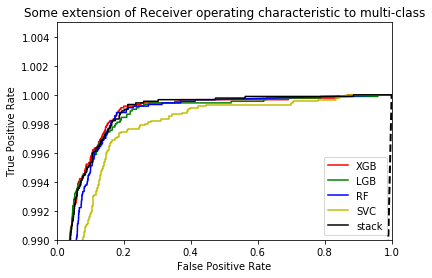

In [30]:
Y_test_=label_binarize(Y_test,classes=[0, 1, 2])

fpr_xgb, tpr_xgb, _ = roc_curve(Y_test_.ravel(), Y_score_xgb.ravel())
fpr_lgb, tpr_lgb, _ = roc_curve(Y_test_.ravel(), Y_score_lgb.ravel())
fpr_RF, tpr_RF, _ = roc_curve(Y_test_.ravel(), Y_score_RF.ravel())
fpr_SVC, tpr_SVC, _ = roc_curve(Y_test_.ravel(), Y_score_SVC.ravel())
fpr_SVC, tpr_SVC, _ = roc_curve(Y_test_.ravel(), Y_score_SVC.ravel())
fpr_stk, tpr_stk, _ = roc_curve(Y_test_.ravel(), Y_score_stack.ravel())



plt.figure()

plt.plot(fpr_xgb, tpr_xgb,
         color='R',label="XGB")
plt.plot(fpr_lgb, tpr_lgb,
         color='G',label='LGB')
plt.plot(fpr_RF, tpr_RF,
         color='B',label='RF')
plt.plot(fpr_SVC, tpr_SVC,
         color='Y',label='SVC')

plt.plot(fpr_stk, tpr_stk,
         color='black',label='stack')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.99, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

最后绘制XGBoost下的特征重要性，特征对应分别是：

f0: P

f1: CosTheta

f2: CosPhi

f3: PH

f4: GoodHit

f5: Tof

f6: E

f7: secp

可以看到，动量P和极角CosTheta对粒子鉴别的重要性最高。方位角CosPhi和击中数GoodHit对粒子鉴别的贡献最低。

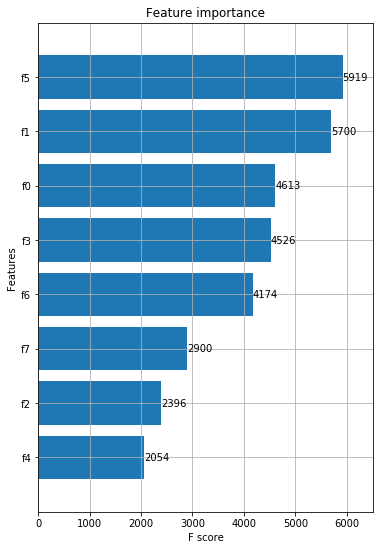

In [130]:
fig, ax = plt.subplots(figsize=(6,9))
xgb.plot_importance(xgb_, height=0.8,ax=ax)
plt.show()

最后可以看一下各个模型的精确率以及召回率。召回率和精确率一般是对二分类样本而言的，对于多样本的话，有两种计算方式，第一种的话是将所有类别样本混合计算：
$$Recall=\frac{\Sigma TP}{\Sigma TP+\Sigma FP}$$
在这种情况下$\Sigma FP$和$\Sigma FN$结果是一样的，所以精确率和召回率就一样了。对应在sklearn.metrics.precision_score和sklearn.metrics.recall_score中的average参数为micro。

第二种计算方式是分别计算每一类的精确率(召回率)再取平均值，对于sklearn中参数为macro。此处采取第二种方式计算。

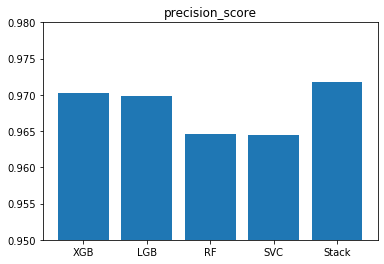

In [138]:
P_score = []
P_score.append(metrics.precision_score(Y_test,y_pred_xgb,average='macro'))
P_score.append(metrics.precision_score(Y_test,y_pred_lgb,average='macro'))
P_score.append(metrics.precision_score(Y_test,y_pred_RF,average='macro'))

P_score.append(metrics.precision_score(Y_test,y_pred_SVC,average='macro'))
P_score.append(metrics.precision_score(Y_test,y_pred_stack,average='macro'))

plt.bar(x=range(0,5),height=P_score)
plt.ylim(0.95,0.98)
label_list=['XGB','LGB','RF','SVC','Stack']
plt.xticks(range(0,5), label_list)
plt.title("precision_score")
plt.show()

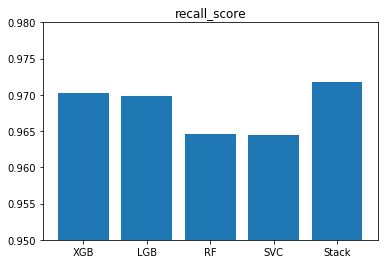

In [139]:
R_score = []
R_score.append(metrics.recall_score(Y_test,y_pred_xgb,average='macro'))
R_score.append(metrics.recall_score(Y_test,y_pred_lgb,average='macro'))
R_score.append(metrics.recall_score(Y_test,y_pred_RF,average='macro'))

R_score.append(metrics.recall_score(Y_test,y_pred_SVC,average='macro'))
R_score.append(metrics.recall_score(Y_test,y_pred_stack,average='macro'))
plt.bar(x=range(0,5),height=P_score)
plt.ylim(0.95,0.98)
label_list=['XGB','LGB','RF','SVC','Stack']
plt.xticks(range(0,5), label_list)
plt.title("recall_score")
plt.show()

# 总结
可以看到，利用集成方法得出的分类准确率(XGB,LGB)会比单一方法(SVC)的准确率高。目前最高的准确率约97.1%。比目前传统方法所用的准确率约高4%。

调参以及数据归一化对分类器准确率的影响十分大，在归一化之前，SVC的准确率大概只有90%。



